In [2]:
import pickle
from pathlib import Path
import numpy as np
import statistics
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
from qutip import *
from qutip.qip.operations import cnot,rz,rx,ry,snot
from qutip.qip.circuit import QubitCircuit
from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter
from qutip import entropy_vn, concurrence
rand_ket_haar(2).purity()
import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *

In [3]:
import pickle
from pathlib import Path
import numpy as np
import jax
import jax.numpy as jnp

def convert_to_float(value):
    """Convert NumPy arrays or other numeric types to float or list of floats."""
    if isinstance(value, np.ndarray):
        return [float(f"{x:.13f}") for x in value]
    elif isinstance(value, (float, int, np.float32, np.float64, np.int32, np.int64)):
        return float(f"{value:.13f}")
    else:
        return value

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        for trainable_params_dict in df[fixed_params_dict].keys():
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict

def find_extreme_params(qfim_eigvals_dict):
    min_trace_val = float('inf')
    max_trace_val = float('-inf')
    min_var_val = float('inf')
    max_var_val = float('-inf')

    min_trace_params = None
    max_trace_params = None
    min_var_params = None
    max_var_params = None

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            trace = np.sum(eigvals)
            variance = np.var(eigvals)

            if trace < min_trace_val:
                min_trace_val = trace
                min_trace_params = (fixed_param, trainable_param)

            if trace > max_trace_val:
                max_trace_val = trace
                max_trace_params = (fixed_param, trainable_param)

            if variance < min_var_val:
                min_var_val = variance
                min_var_params = (fixed_param, trainable_param)

            if variance > max_var_val:
                max_var_val = variance
                max_var_params = (fixed_param, trainable_param)

    return {
        "min_trace": (min_trace_params, min_trace_val),
        "max_trace": (max_trace_params, max_trace_val),
        "min_variance": (min_var_params, min_var_val),
        "max_variance": (max_var_params, max_var_val)
    }

def find_average_extreme_params(qfim_eigvals_dict):
    avg_trace_dict = {}
    avg_var_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        traces = [np.sum(eigvals) for eigvals in trainable_dict.values()]
        variances = [np.var(eigvals) for eigvals in trainable_dict.values()]

        avg_trace_dict[fixed_param] = np.mean(traces)
        avg_var_dict[fixed_param] = np.mean(variances)

    min_avg_trace_val = min(avg_trace_dict.values())
    max_avg_trace_val = max(avg_trace_dict.values())
    min_avg_var_val = min(avg_var_dict.values())
    max_avg_var_val = max(avg_var_dict.values())

    min_avg_trace_key = min(avg_trace_dict, key=avg_trace_dict.get)
    max_avg_trace_key = max(avg_trace_dict, key=avg_trace_dict.get)
    min_avg_var_key = min(avg_var_dict, key=avg_var_dict.get)
    max_avg_var_key = max(avg_var_dict, key=avg_var_dict.get)

    return {
        "avg_trace_dict": avg_trace_dict,
        "avg_var_dict": avg_var_dict,
        "min_avg_trace": (min_avg_trace_key, min_avg_trace_val),
        "max_avg_trace": (max_avg_trace_key, max_avg_trace_val),
        "min_avg_variance": (min_avg_var_key, min_avg_var_val),
        "max_avg_variance": (max_avg_var_key, max_avg_var_val)
    }

def analyze_qfim_for_different_k_factors(file_paths):
    results_dict = {}
    for file_path in file_paths:
        k_factor = file_path.parent.name
        qfim_eigvals_dict = get_qfim_eigvals(file_path)
        if qfim_eigvals_dict is not None:
            results = find_extreme_params(qfim_eigvals_dict)
            avg_results = find_average_extreme_params(qfim_eigvals_dict)
            results_dict[k_factor] = {
                "extreme": results,
                "average": avg_results
            }
    return results_dict

# List of file paths for different K factors
file_paths = [
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/0.01K/data.pickle'),
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/0.1K/data.pickle'),
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/1.0K/data.pickle'),
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/10K/data.pickle')
]

results_dict = analyze_qfim_for_different_k_factors(file_paths)

# Display the results
for k_factor, results in results_dict.items():
    print(f"\nResults for K factor {k_factor}:")
    print(f"Minimum trace: {results['extreme']['min_trace']}")
    print(f"Maximum trace: {results['extreme']['max_trace']}")
    print(f"Minimum variance: {results['extreme']['min_variance']}")
    print(f"Maximum variance: {results['extreme']['max_variance']}")
    print(f"Minimum average trace: {results['average']['min_avg_trace']}")
    print(f"Maximum average trace: {results['average']['max_avg_trace']}")
    print(f"Minimum average variance: {results['average']['min_avg_variance']}")
    print(f"Maximum average variance: {results['average']['max_avg_variance']}")

File /Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/1.0K/data.pickle does not exist.

Results for K factor 0.01K:
Minimum trace: (('fixed_params11', 'test17'), Array(7.261581, dtype=float32))
Maximum trace: (('fixed_params15', 'test16'), Array(176.66483, dtype=float32))
Minimum variance: (('fixed_params2', 'test17'), Array(2.978995, dtype=float32))
Maximum variance: (('fixed_params15', 'test16'), Array(3818.6204, dtype=float32))
Minimum average trace: ('fixed_params9', 46.640488)
Maximum average trace: ('fixed_params10', 47.580666)
Minimum average variance: ('fixed_params3', 419.74463)
Maximum average variance: ('fixed_params10', 452.1407)

Results for K factor 0.1K:
Minimum trace: (('fixed_params10', 'test13'), Array(3.195957, dtype=float32))
Maximum trace: (('fixed_params1', 'test10'), Array(211.1723, dtype=float32))
Minimum variance: (('fixed_params10', 'test13'), Array(0.42058173, dtype=float32))
Maximum variance: (('fixe

In [ ]:
threshold = 1e-14

def process_params(params):
    """Process a dictionary of parameters, converting all numeric values to floats or lists of floats."""
    #print(params)
    return {key: convert_to_float(value) for key, value in params.items()}
def convert_to_float(value):
    """Convert NumPy arrays or other numeric types to float or list of floats."""
    if isinstance(value, np.ndarray):
        # Convert NumPy array to list of floats
        return [float(f"{x:.13f}") for x in value]
    elif isinstance(value, (float, int, np.float32, np.float64, np.int32, np.int64)):
        # Convert single numeric value to float
        return float(f"{value:.13f}")
    else:
        # Return the value as-is if it's not a recognized numeric type
        return value
    
def convert_to_hashable(value):
    """Convert unhashable types (e.g., NumPy arrays) to hashable types (e.g., tuples)."""
    if isinstance(value, np.ndarray):
        return tuple(value.tolist())  # Convert arrays to tuples
    elif isinstance(value, list):
        return tuple(value)  # Convert lists to tuples
    else:
        return value

def process_params_for_hashing(params):
    """Process a dictionary of parameters, converting all values to hashable types."""
    return {key: convert_to_hashable(value) for key, value in params.items()}

some_results = {}


def find_max_variance_params(file_path, metric,track):
    """
    Load data from a pickle file and find the parameters with the maximum mean variance of the qfim eigenvalues.

    Parameters:
    - file_path: Path object or str, the path to the pickle file.
    - metric: str, the metric to compare, e.g., 'mean_var_eigval' for mean variance of the qfim eigenvalues.

    Returns:
    Tuple of dictionaries for the fixed and trainable parameters with the maximum value of the specified metric.
    """
    # Ensure file_path is a Path object
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    min_trace = np.inf
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    
    max_result = -np.inf
    min_result = np.inf
    max_fixed_params = None
    max_trained_params = {}
    min_fixed_params = None
    min_trained_params = {}
    
    qfim_eigvals_dict = {}
    fixed_params_values_dict = {}
    
    for i, fixed_params_dict in enumerate(df.keys()):
        for test in df[fixed_params_dict].keys():
            #if  test == 'test13' or test == 'test14' or test =='test19':
            #    continue
            if test == 'test14' or test =='test13':
                continue
            results = df[fixed_params_dict][test]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
                res = np.var(qfim_eigvals)
                trace = np.sum(nonzero_eigvals)
                #print(test,trace, min_trace)
                
                if trace < min_trace and fixed_params_dict == track:
                    min_trace = trace
                    
                    min_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    min_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in min_trainableparams]) + ']'
                    min_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    min_trained_params[fixed_params_dict] = {test:{"trace":trace,"params":min_trainableparams,
                                                                   "eigvals":min_trainableparams_eigvals}} 
                if trace > max_result and fixed_params_dict == track:
                    max_result = trace
                    
                    max_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    max_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in max_trainableparams]) + ']'
                    max_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    max_trained_params[fixed_params_dict] =  {test:{"trace":trace,"params":max_trainableparams,
                                                                   "eigvals":max_trainableparams_eigvals}} 
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = []
                
                qfim_eigvals_dict[fixed_params_dict].append(qfim_eigvals)
                if fixed_params_dict not in fixed_params_values_dict:
                    fixed_params_values_dict[fixed_params_dict] = {}
                
                fixed_params_values_dict[fixed_params_dict]['fixed_params'] = results.get('fixed_params', {})
        
    return qfim_eigvals_dict, fixed_params_values_dict,min_trace,min_trainableparams,max_result,max_trainableparams,max_trained_params,min_trained_params



# List of file paths for different K factors
file_paths = [
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/0.01K/data.pickle'),
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/0.1K/data.pickle'),
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/1.0K/data.pickle'),
    Path('/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_1/GHZ_state/Nr_3/trotter_step_1/10K/data.pickle')
]
param_set_key = 'fixed_params0'
for file_path in file_paths:

    qfim_eigvals_dict, fixed_params_values_dict,min_trace,min_trainableparams,max_trace,max_trainableparams,max_trained_params,min_trained_params = find_max_variance_params(file_path, '',param_set_key)

    print(fixed_params_values_dict[param_set_key])

In [ ]:
results_dict.keys()
for k_factor, results in results_dict.items():
    print(k_factor)
    print(results[])

In [13]:
import pickle
from pathlib import Path

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        for trainable_params_dict in df[fixed_params_dict].keys():
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict

def read_and_select_trainable_params(file_path, fixed_param_key):
    qfim_eigvals_dict = get_qfim_eigvals(file_path)
    if qfim_eigvals_dict is None or fixed_param_key not in qfim_eigvals_dict:
        print(f"No data found for fixed_param_key: {fixed_param_key}")
        return []

    params_sorted_by_qfim_trace = {}
    params_sorted_by_qfim_var = {}
    params_sorted_by_qfim_eigvals = {}
    key_and_params = {}

    for trainable_params_dict, results in qfim_eigvals_dict[fixed_param_key].items():
        qfim_eigvals = results
        trace = float(np.sum(qfim_eigvals))
        variance = float(np.var(qfim_eigvals))

        params_sorted_by_qfim_trace[trainable_params_dict] = trace
        params_sorted_by_qfim_var[trainable_params_dict] = variance
        key_and_params[trainable_params_dict] = trainable_params_dict
        params_sorted_by_qfim_eigvals[trainable_params_dict] = qfim_eigvals
    print(len(qfim_eigvals_dict['fixed_params0']))
    sorted_qfim_trace = sorted(params_sorted_by_qfim_trace.items(), key=lambda x: float(x[1]))

    # Calculate the number of parameters to select
    number_of_tests = len(sorted_qfim_trace)
    num_to_select = number_of_tests // 2
    interval_size = number_of_tests / num_to_select

    selected_params = []
    selected_params_with_vals = []

    for i in range(num_to_select):
        start_idx = int(i * interval_size)
        end_idx = int((i + 1) * interval_size)
        interval = sorted_qfim_trace[start_idx:end_idx]
        midpoint = (interval[0][1] + interval[-1][1]) / 2
        closest_param = min(interval, key=lambda x: abs(x[1] - midpoint))
        selected_params.append(closest_param[0])
        selected_params_with_vals.append(closest_param)

    smallest_key = sorted_qfim_trace[0][0]
    for i in range(1, 6):
        key = sorted_qfim_trace[-i][0]
        if key not in selected_params:
            selected_params.append(key)
            selected_params_with_vals.append((key, params_sorted_by_qfim_trace[key]))

    if smallest_key not in selected_params:
        selected_params.append(smallest_key)
        selected_params_with_vals.append((smallest_key, params_sorted_by_qfim_trace[smallest_key]))
    
    return selected_params, selected_params_with_vals,sorted_qfim_trace,qfim_eigvals_dict

# Example usage
N_ctrl = 2
Nr = 1
trotter_step = 10
state = 'GHZ'
kfactor = 1
base_path = f'/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_{N_ctrl}/{state}_state/1xK/'

file_path = Path(base_path) / f'Nr_{Nr}' / f'trotter_step_{trotter_step}' / 'data.pickle'
fixed_param_key = 'fixed_params15'

selected_params, selected_params_with_vals,sorted_qfim_trace,qfim_eigvals_dict = read_and_select_trainable_params(file_path, fixed_param_key)

print("Selected Parameters:", selected_params)
print("Selected Parameters with Values:", selected_params_with_vals)


File /Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model/Nc_2/GHZ_state/1xK/Nr_1/trotter_step_10/data.pickle does not exist.
No data found for fixed_param_key: fixed_params15


ValueError: not enough values to unpack (expected 4, got 0)

In [ ]:
smallest_key = sorted_qfim_trace[0][0]
print(f"min: {smallest_key}")
print(f"max: {sorted_qfim_trace[-1][0]}")

In [ ]:
qfim_eigvals_dict['fixed_params15']

In [ ]:

def get_qfim_eigvals(file_path, fixed_param_dict_key, trainable_param_dict_key):
    """
    Load data from a pickle file and return QFIM eigenvalues for the given fixed and trainable parameter dictionary keys.

    Parameters:
    - file_path: str or Path, the path to the pickle file.
    - fixed_param_dict_key: str, the key for the fixed parameters dictionary.
    - trainable_param_dict_key: str, the key for the trainable parameters dictionary.

    Returns:
    - qfim_eigvals: list of QFIM eigenvalues.
    """
    # Ensure file_path is a Path object
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    
    # Initialize variables
    qfim_eigvals = None
    
    for fixed_params_dict in df.keys():
        if fixed_params_dict == fixed_param_dict_key:
            for trainable_params_dict in df[fixed_params_dict].keys():
                if trainable_params_dict == trainable_param_dict_key:
                    results = df[fixed_params_dict][trainable_params_dict]
                    if 'qfim_eigvals' in results:
                        qfim_eigvals = results['qfim_eigvals']
                        fixed_params = results['fixed_params']
                        params = results['trainable_params']
                        return qfim_eigvals,fixed_params,params
    
    print("QFIM eigenvalues not found for the given parameter keys.")
    return None,None,None

eigvals, fixed_params_dict,params = get_qfim_eigvals(file_path, 'fixed_params15', 'test1')
print(fixed)

### <b> Fidelity Results for Parameter Selection </b>

In [39]:
# Function to read data from pickle files
def read_data(fixed_param_name, file_path):
    data = {}
    for train_size in train_sizes:
        train_path = os.path.join(file_path, f'{train_size}_training_states', fixed_param_name)
        if not os.path.exists(train_path):
            continue
        for test_key in os.listdir(train_path):
            test_path = os.path.join(train_path, test_key)
            if not os.path.isdir(test_path):
                continue
            for folder_name in sorted(os.listdir(test_path)):
                if folder_name.startswith(gate_prefix + "_"):
                    gate = folder_name
                    print(gate)
                    pickle_file = os.path.join(test_path, folder_name, f'{test_key}.pickle')
                    if os.path.isfile(pickle_file):
                        with open(pickle_file, 'rb') as f:
                            df = pickle.load(f)
                            if 'costs' in df and 'testing_results' in df:
                                if test_key not in data:
                                    data[test_key] = {'costs': df['costs'], 'testing_results': df['testing_results']}
    return data
# Function to read data from pickle files and organize by gate
def read_data_by_gate(fixed_param_name, file_path):
    data_by_gate = {}
    for train_size in train_sizes:
        train_path = os.path.join(file_path, f'{train_size}_training_states', fixed_param_name)
        if not os.path.exists(train_path):
            continue
        for test_key in os.listdir(train_path):
            test_path = os.path.join(train_path, test_key)
            if not os.path.isdir(test_path):
                continue
            for folder_name in sorted(os.listdir(test_path)):
                if folder_name.startswith(gate_prefix + "_"):
                    gate = folder_name
                    pickle_file = os.path.join(test_path, folder_name, f'data_run_2.pickle')
                    if os.path.isfile(pickle_file):
                        with open(pickle_file, 'rb') as f:
                            df = pickle.load(f)
                            if 'costs' in df and 'testing_results' in df:
                                if gate not in data_by_gate:
                                    data_by_gate[gate] = {}
                                if test_key not in data_by_gate[gate]:
                                    data_by_gate[gate][test_key] = {'costs': df['costs'][0], 'testing_results': df['testing_results'][0]}
    print(data_by_gate['U1_0'].keys())
    return data_by_gate
# Function to plot cost history per epoch for each gate
def plot_cost_history_by_gate(data_by_gate, fixed_param_name):
    for gate, data in data_by_gate.items():
        plt.figure(figsize=(10, 6))
        for test_key, results in data.items():
            costs = results['costs']
            plt.plot(costs, label=f'{test_key}')
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title(f'Cost History for {fixed_param_name} - {gate}')
        plt.legend()
        plt.show()

# Function to plot fidelity distribution of testing results for each gate
def plot_fidelity_distribution_by_gate(data_by_gate, fixed_param_name):
    for gate, data in data_by_gate.items():
        plt.figure(figsize=(10, 6))
        for test_key, results in data.items():
            fidelities = results['testing_results']
            plt.hist(fidelities, bins=50, alpha=0.5, label=f'{test_key}')
        plt.xlabel('Fidelity')
        plt.ylabel('Frequency')
        plt.title(f'Fidelity Distribution for {fixed_param_name} - {gate}')
        plt.legend()
        plt.show()
# Function to plot cost history per epoch
def plot_cost_history(data, fixed_param_name, color):
    plt.figure(figsize=(10, 6))
    for test_key, results in data.items():
        costs = results['costs']
        plt.plot(costs, label=f'{test_key}', color=color)
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title(f'Cost History for {fixed_param_name}')
    plt.legend()
    plt.show()
# Function to plot fidelity distribution of testing results
def plot_fidelity_distribution(data, fixed_param_name, color):
    plt.figure(figsize=(10, 6))
    for test_key, results in data.items():
        fidelities = results['testing_results']
        plt.hist(fidelities, bins=50, alpha=0.5, label=f'{test_key}', color=color)
    plt.xlabel('Fidelity')
    plt.ylabel('Frequency')
    plt.title(f'Fidelity Distribution for {fixed_param_name}')
    plt.legend()
    plt.show()


In [61]:

# Function to read data from pickle files and organize by gate
def read_data_by_gate(fixed_param_name, file_path):
    data_by_gate = {}
    for train_size in train_sizes:
        train_path = os.path.join(file_path, f'{train_size}_training_states_no_opt', fixed_param_name, '1.0K')
        if not os.path.exists(train_path):
            print(f"Not a dir: {train_path}")
            continue
        for test_key in os.listdir(train_path):
            test_path = os.path.join(train_path, test_key)
            print(test_path)
            if not os.path.isdir(test_path):
                continue
            for folder_name in sorted(os.listdir(test_path)):
                if folder_name.startswith(gate_prefix + "_"):
                    gate = folder_name
                    pickle_file = os.path.join(test_path, folder_name, f'data_run_0.pickle')
                    if os.path.isfile(pickle_file):
                        with open(pickle_file, 'rb') as f:
                            df = pickle.load(f)
                            if 'costs' in df and 'testing_results' in df:
                                try:
                                    costs = df['costs'][0]
                                    testing_results = df['testing_results'][0]
                                    if gate not in data_by_gate:
                                        data_by_gate[gate] = {}
                                    if test_key not in data_by_gate[gate]:
                                        data_by_gate[gate][test_key] = {'costs': costs, 'testing_results': testing_results}
                                except IndexError:
                                    print(f"Error accessing costs or testing_results in {pickle_file}")
    return data_by_gate

# Function to plot cost history per epoch and fidelity distribution for each gate
def plot_cost_and_fidelity_by_gate(data_by_gate, fixed_param_name):
    for gate, data in data_by_gate.items():
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
        
        # Plot cost history
        for test_key, results in data.items():
            costs = results['costs']
            if not isinstance(costs, (list, np.ndarray)):
                print(f"Skipping {test_key} in {gate} due to invalid costs format")
                continue
            axes[0].plot(costs, label=f'{test_key}')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Cost')
        axes[0].set_title(f'Cost History for {fixed_param_name} - {gate}',fontsize=20)
        axes[0].axhline(y=0.0, color='r', linestyle='--')
        axes[0].legend(fontsize=20)
        
        # Plot fidelity distribution
        for test_key, results in data.items():
            fidelities = results['testing_results']
            #print(fidelities)
            #if not isinstance(fidelities, (list, np.ndarray)):
             #   print(f"Skipping {test_key} in {gate} due to invalid fidelities format")
             #   continue
            axes[1].hist(fidelities, bins=50, alpha=0.5, label=f'{test_key}')
        axes[1].set_xlabel('Fidelity')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title(f'Fidelity Distribution for {fixed_param_name} - {gate}',fontsize=20)
        axes[1].legend(fontsize=20)
        
        plt.tight_layout()
        plt.show()
#fixed_params = ['fixed_params28','fixed_params15','fixed_params2x3']
fixed_params = ['fixed_params0']
# color_map = {
#     'fixed_params28': 'orange',
#     'fixed_params15': 'blue',
#     'fixed_params2x3': 'green',
#     'fixed_params15x3':'purple'
    
# }
data_results = {}
train_sizes = [5]
N_r = 1
trotter_step = 2
N_ctrl = 1
gate_prefix = f'U{N_ctrl}'
base_path = f'/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/'
#/Users/sophieblock/QRCCapstone/param_initialization/digital_results_trainable_global/Nc_2/reservoirs_1/trotter_step_10/fixed_params0/15_training_states_gradlr/fixed_params0/test48/U2_9/test48.pickle
# Process each fixed parameter set and plot the results for each gate
for fixed_param_name in fixed_params:
    file_path = base_path
    data_by_gate = read_data_by_gate(fixed_param_name, file_path)
    if data_by_gate:
        data_results[fixed_param_name] = data_by_gate
        # plot_cost_and_fidelity_by_gate(data_by_gate, fixed_param_name)

# ./param_initialization/analog_results/Nc_1//reservoirs_1/trotter_step_2/10_training_states_no_opt/fixed_params0_1.0K/test125/U1_20/data_run_0.pickle

/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_2/5_training_states_no_opt/fixed_params0/1.0K/test44
/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_2/5_training_states_no_opt/fixed_params0/1.0K/test50
/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_2/5_training_states_no_opt/fixed_params0/1.0K/test121
/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_2/5_training_states_no_opt/fixed_params0/1.0K/test94
/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_2/5_training_states_no_opt/fixed_params0/1.0K/test23
/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_2/5_training_states_no_opt/fixed_params0/1.0K/test22
/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_

In [4]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
train_sizes = [20]
def compute_qfim_entropy(eigvals, threshold=1e-12):
    # Filter eigenvalues that are larger than the threshold
    filtered_eigvals = eigvals[eigvals > threshold]
    
    # Normalize the eigenvalues to form a probability distribution
    normalized_eigvals = filtered_eigvals / jnp.sum(filtered_eigvals)
    
    # Compute the entropy
    entropy = -jnp.sum(normalized_eigvals * jnp.log(normalized_eigvals + 1e-12))  # Adding a small value to avoid log(0)
    
    return entropy
# Function to read data from pickle files and organize by gate
def read_data_by_gate(fixed_param_name, file_path):
    data_by_test_key = {}
    dqfim_results = {}
    data_by_train_size = {}
    data_by_test_key_bygate = {}
    gates = []
    results = []
    for train_size in train_sizes:
        data_by_train_size[train_size] = {}
        data_trainsize = data_by_train_size[train_size]
        # train_size = 10
        train_path = os.path.join(file_path, f'{train_size}_training_states_random', fixed_param_name)
        if not os.path.exists(train_path):
            print(f"Not a dir: {train_path}")
            continue
        for test_key in os.listdir(train_path):
            test_path = os.path.join(train_path, test_key)
            if not os.path.isdir(test_path):
                continue
            for folder_name in sorted(os.listdir(test_path)):
                if folder_name.startswith(gate_prefix + "_"):
                    gate = folder_name
                    pickle_file = os.path.join(test_path, folder_name, f'data_run_0.pickle')
                    if os.path.isfile(pickle_file):
                        gates.append(gate)
                        # if int(gate.split('_')[-1]) > 8:
                        #     continue
                        with open(pickle_file, 'rb') as f:
                            df = pickle.load(f)
                            if 'costs' in df and 'testing_results' in df:
                                try:
                                    costs = [float(cost) for cost in df['costs'][0]]
                                    
                                    # Load DQFIM eigenvalues
                                    dqfim_data = df['DQFIM_target_states'][0]
                                    vn_entropies = dqfim_data['entropies']
                                    dqfim_eigvals = dqfim_data['dqfim_eigvals']


                                    # Set eigenvalues below the threshold (whether positive or negative) to zero
                                    numerical_threshold = 1e-12
                                    dqfim_nonzero = np.array([el if np.abs(el) > numerical_threshold else 0 for el in dqfim_eigvals])

                                    # Assertion check for any remaining large negative eigenvalues
                                    assert jnp.all(jnp.array(dqfim_nonzero) >= 0), (
                                        f"Found large negative DQFIM eigenvalues in test_key {test_key}, "
                                        f"corrected eigvals: {dqfim_nonzero}, original eigvals: {dqfim_eigvals}"
                                    )
                                    
                                    dqfim_trace = jnp.sum(dqfim_data['dqfim_eigvals'])
                                    dqfim_var_nonzero = np.var(dqfim_nonzero)
                                    dqfim_condition = np.max(dqfim_data['dqfim_eigvals']) / np.min(dqfim_data['dqfim_eigvals'][dqfim_data['dqfim_eigvals'] > 1e-12])
                                    dqfim_entropy = compute_qfim_entropy(dqfim_eigvals)
                                    # dqfim_results[test_key] = {
                                    #     'trace': dqfim_trace,
                                    #     'variance': dqfim_var_nonzero,
                                    #     'condition': dqfim_condition,
                                    #     'entropy': dqfim_entropy
                                    # }
                                    # Append results as a dictionary (one row per gate)
                                    results.append({
                                        'gate': gate,
                                        'test_key': test_key,
                                        'avg_fidelity': np.mean(df['testing_results'][0]),
                                        'dqfim_trace': dqfim_trace,
                                        'dqfim_variance': dqfim_var_nonzero,
                                        'dqfim_condition': dqfim_condition,
                                        'dqfim_entropy': dqfim_entropy,
                                        'vn_entropies':np.mean(vn_entropies)
                                    })
                                    
                                    # print(len(df['training_states'][0]))
                                    testing_results = [float(res) for res in df['testing_results'][0]]
                                    if test_key not in data_by_test_key:
                                        data_by_test_key[test_key] = []
                                        data_by_test_key_bygate[test_key] = []
                                        # data_by_test_key[test_key] = {}
                                    if test_key not in data_trainsize:
                                        data_trainsize[test_key] = []
                                    data_by_test_key[test_key].extend(testing_results)
                                    data_by_test_key_bygate[test_key].extend([np.mean(testing_results)])
                                    data_trainsize[test_key].extend(testing_results)
                                except IndexError:
                                    print(f"Error accessing costs or testing_results in {pickle_file}")
    print(f"Num gates: {len(gates)}")
    results_df = pd.DataFrame(results)
    return data_by_test_key,dqfim_results,data_by_train_size, results_df


data_results = {}
fixed_param_name = 'fixed_params0/2pi'
N_r = 1
trotter_step = 1
N_ctrl = 1
gate_prefix = f'U{N_ctrl}'
base_path = f'/Users/sophieblock/QRCCapstone/param_initialization_final/analog_results/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/'
file_path = base_path
data_by_test_key,dqfim_results,data_by_train_size, df = read_data_by_gate(fixed_param_name, file_path)


Num gates: 775


In [72]:
df_U1_6 = df[df['gate'] == 'U1_1']
df_U1_6

,gate,test_key,avg_fidelity,dqfim_trace,dqfim_variance,dqfim_condition,dqfim_entropy,vn_entropies
1,U1_1,test20,0.759762,0.238346,0.004315,1.027027e+03,0.615466,0.377818
11,U1_1,test80,0.995247,0.061384,0.000570,1.368207e+04,0.107973,0.136330
21,U1_1,test73,0.948536,60.654411,584.839896,1.125096e+05,0.018039,0.338789
31,U1_1,test89,0.788386,0.068138,0.000593,1.049819e+05,0.298579,0.000977
41,U1_1,test42,0.825385,26.140074,109.035662,1.471682e+06,0.008413,0.219816
49,U1_1,test43,0.960227,11.487712,20.105438,1.155248e+04,0.096633,0.171082
57,U1_1,test6,0.846617,181.982391,5296.955508,1.256780e+06,0.001390,0.276637
67,U1_1,test1,0.880589,217.665833,7579.282921,9.898096e+04,0.000736,0.331356
77,U1_1,test8,0.958601,111.262291,1977.501972,5.682934e+05,0.005386,0.301875
85,U1_1,test57,0.942015,175.378311,4915.966455,5.528882e+07,0.003734,0.222454


In [7]:
columns_to_convert = ['avg_fidelity', 'dqfim_trace', 'dqfim_variance', 'dqfim_condition', 'dqfim_entropy','vn_entropies']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
for col in columns_to_convert:
    df[col] = df[col].apply(lambda x: np.asarray(x) if isinstance(x, jax.Array) else x)
print(df.dtypes)
# Check for non-numeric entries in the problematic columns
# for col in columns_to_convert:
#     non_numeric_values = df[~df[col].apply(lambda x: pd.to_numeric(x, errors='coerce').notnull())][col]
#     print(f"Non-numeric entries in {col}:")
#     print(non_numeric_values)


gate                object
test_key            object
avg_fidelity       float64
dqfim_trace        float64
dqfim_variance     float64
dqfim_condition    float64
dqfim_entropy      float64
vn_entropies       float64
dtype: object


In [8]:
numeric_columns = df.select_dtypes(include=[float, int]).columns

# Group by 'test_key' and compute the mean for numeric columns only
df_grouped = df.groupby('test_key')[numeric_columns].mean().reset_index()

# Display the new DataFrame with averaged values
print(df_grouped)

   test_key  avg_fidelity  dqfim_trace  dqfim_variance  dqfim_condition  \
0     test1      0.895592   189.699823     5923.737798     5.259812e+05   
1    test15      0.885452   130.913036     2840.208342     3.591410e+06   
2    test20      0.920940     0.260898        0.008127     5.933034e+02   
3    test32      0.932831    50.828808      438.650825     4.284833e+05   
4    test33      0.861642     0.043163        0.000503     1.530229e+06   
5    test34      0.907897    25.286006      109.635112     1.934864e+04   
6    test36      0.962327   101.877503     1689.191546     5.292092e+04   
7    test40      0.908974    40.584292      277.387393     1.006052e+07   
8    test41      0.857146    13.102260       29.189093     8.255023e+07   
9    test42      0.905629    31.567692      171.228348     1.394829e+07   
10   test43      0.919489    15.444254       40.388313     7.662669e+04   
11   test53      0.941503    81.276962     1089.486530     3.154357e+07   
12   test57      0.930739

In [111]:
df_grouped

,test_key,avg_fidelity,dqfim_trace,dqfim_variance,dqfim_condition,dqfim_entropy,vn_entropies
0,test1,0.899931,191.222222,6014.677655,4.556824e+05,0.006705,0.288573
1,test15,0.889583,132.064250,2885.373718,3.713755e+06,0.050841,0.491240
2,test20,0.921870,0.256800,0.007797,5.925255e+02,0.465314,0.402605
3,test33,0.864662,0.043770,0.000517,1.566349e+06,0.002260,0.003606
4,test41,0.858265,13.100356,29.251458,8.397984e+07,0.055536,0.086849
5,test42,0.905629,31.567692,171.228348,1.394829e+07,0.011783,0.224371
6,test43,0.915760,15.215357,39.180652,7.915912e+04,0.044179,0.155146
7,test53,0.948089,81.816381,1102.953970,3.278463e+07,0.006525,0.188115
8,test57,0.929393,162.636825,4295.189180,3.509679e+07,0.003329,0.221768
9,test6,0.894110,177.464406,5243.914726,1.634357e+06,0.001575,0.284039


[('test33', 0.8616417558249589), ('test60', 0.8660206141363125), ('test80', 0.880261005305962), ('test89', 0.8843125562561123), ('test20', 0.9209399968788431)]
test20: Tr(Q) = 0.2609, Var(λ) = 8.13e-03, κ = 5.93e+02, S = 0.460, S_VN = 0.402
test89: Tr(Q) = 0.0738, Var(λ) = 1.21e-03, κ = 3.93e+03, S = 0.312, S_VN = 0.001
test80: Tr(Q) = 0.0856, Var(λ) = 9.39e-04, κ = 7.09e+03, S = 0.321, S_VN = 0.123
test60: Tr(Q) = 0.3123, Var(λ) = 2.70e-02, κ = 3.30e+03, S = 0.210, S_VN = 0.327
test33: Tr(Q) = 0.0432, Var(λ) = 5.03e-04, κ = 1.53e+06, S = 0.002, S_VN = 0.004


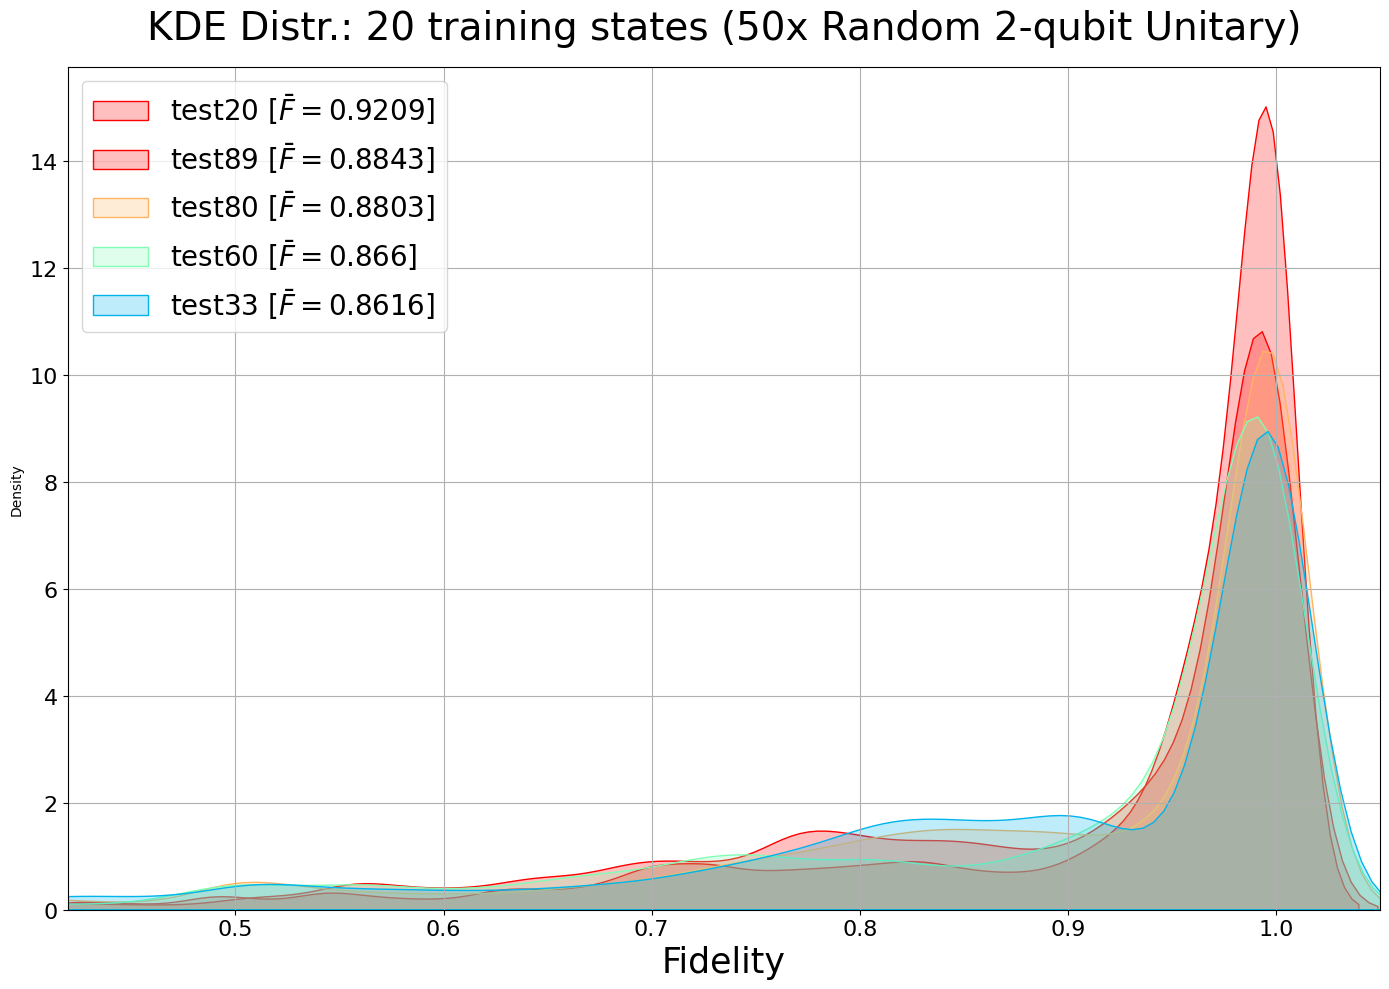

In [9]:
# Function to plot combined KDE of fidelity distributions with average fidelity scores
def plot_combined_kde_fidelity(data_by_test_key,trainsize, df_grouped, include=None):
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.grid(True, zorder=10)
    min_val = np.inf
    # Plot KDE for each test_key with a different color
    plot_results, plot_results_sorted = {}, {}

    # Filter and collect fidelities
    for test_key, fidelities in data_by_test_key.items():
        if include is None or test_key in include:
            temp_min = min(fidelities)
            if temp_min < min_val:
                min_val = temp_min
            plot_results[test_key] = fidelities
            plot_results_sorted[test_key] = np.mean(fidelities)

    # Sort by average fidelities
    plot_results_sorted = sorted(plot_results_sorted.items(), key=lambda x: float(np.mean(x[1])))
    print(plot_results_sorted)

    # Create a colormap based on the number of tests to display
    cmap = plt.get_cmap('rainbow', len(plot_results_sorted))
    
    # Create a colormap based on the number of tests to display
    cmap = plt.get_cmap('rainbow', len(plot_results_sorted))
    
    # Reverse the order of the colors
    # colors = {test_key: cmap(len(plot_results_sorted) - 1 - i) for i, (test_key, _) in enumerate(plot_results_sorted)}
    colors = {test_key: cmap(i+1) for i, (test_key, _) in enumerate(plot_results_sorted)}

    # Reverse the order of plot_results_sorted for layering (so lower fidelities plot first)
    for i, (test_key, avg_fidelity) in enumerate(reversed(plot_results_sorted)):  # <-- Reversed here
        fidelities = plot_results[test_key]
        # Get the row in df_grouped corresponding to the current test_key
        row = df_grouped.loc[df_grouped['test_key'] == test_key]
        print(f"{test_key}: Tr(Q) = {row['dqfim_trace'].values[0]:.4f}, Var(λ) = {row['dqfim_variance'].values[0]:.2e}, κ = {row['dqfim_condition'].values[0]:.2e}, S = {row['dqfim_entropy'].values[0]:.3f}, S_VN = {row['vn_entropies'].values[0]:.3f}")

        sns.kdeplot(fidelities, ax=ax, fill=True, multiple="layer", 
                    color=colors[test_key], label=test_key + f" [$\\bar{{F}} = {round(avg_fidelity,4)}$]")

    # Customize plot
    ax.set_xlabel('Fidelity', fontsize=25)
    ax.set_xlim(min_val+.3, 1.05)
    ax.set_title(f'KDE Distr.: {trainsize} training states (50x Random 2-qubit Unitary)', fontsize=28, pad = 20)
    ax.legend(loc='upper left', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()
# display =['test1','test6','test73', 'test15','test57']
# display =['test8','test53','test66', 'test96','test42']
display =['test33','test89','test80', 'test60','test20']
for trainsize in train_sizes:
    # plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,fixed_param_name,include = ['test22','test50','test44','test2','test104', 'test88','test146','test138', 'test63'] )
    plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,df_grouped,include = display )
    

[('test15', 0.8854516358697737), ('test1', 0.8955916987665602), ('test6', 0.8977003294877909), ('test57', 0.9307392836704448)]
test57: Tr(Q) = 162.3056, Var(λ) = 4.28e+03, κ = 3.33e+07, S = 0.003, S_VN = 0.221
test6: Tr(Q) = 178.9816, Var(λ) = 5.33e+03, κ = 1.61e+06, S = 0.002, S_VN = 0.287
test1: Tr(Q) = 189.6998, Var(λ) = 5.92e+03, κ = 5.26e+05, S = 0.007, S_VN = 0.287
test15: Tr(Q) = 130.9130, Var(λ) = 2.84e+03, κ = 3.59e+06, S = 0.052, S_VN = 0.492


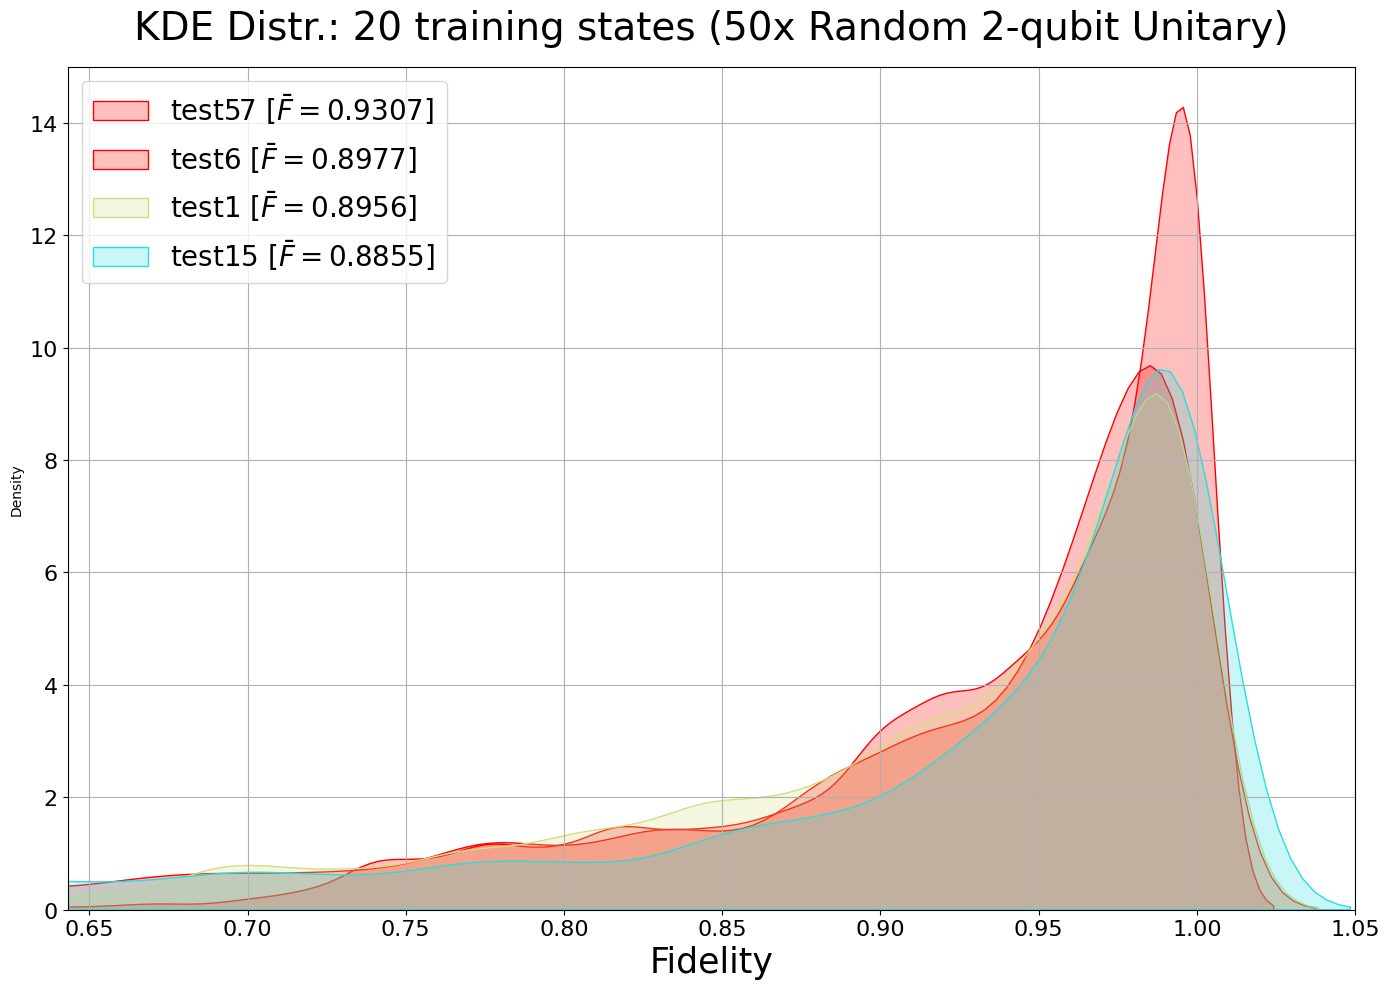

In [10]:
display =['test1','test6','test15','test57'] 
# display =['test33','test89','test80', 'test60','test20']
for trainsize in train_sizes:
    # plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,fixed_param_name,include = ['test22','test50','test44','test2','test104', 'test88','test146','test138', 'test63'] )
    plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,df_grouped,include = display )
    

[('test42', 0.9056292973958677), ('test43', 0.9194893869717379), ('test8', 0.9219598835822075), ('test66', 0.9303745442838283), ('test53', 0.9415031364535963), ('test96', 0.9526296218500749)]
test96: Tr(Q) = 29.1614, Var(λ) = 1.38e+02, κ = 3.66e+05, S = 0.051, S_VN = 0.081
test53: Tr(Q) = 81.2770, Var(λ) = 1.09e+03, κ = 3.15e+07, S = 0.007, S_VN = 0.188
test66: Tr(Q) = 65.2026, Var(λ) = 7.00e+02, κ = 2.22e+07, S = 0.014, S_VN = 0.154
test8: Tr(Q) = 102.8865, Var(λ) = 1.77e+03, κ = 1.48e+07, S = 0.018, S_VN = 0.291
test43: Tr(Q) = 15.4443, Var(λ) = 4.04e+01, κ = 7.66e+04, S = 0.044, S_VN = 0.155
test42: Tr(Q) = 31.5677, Var(λ) = 1.71e+02, κ = 1.39e+07, S = 0.012, S_VN = 0.224


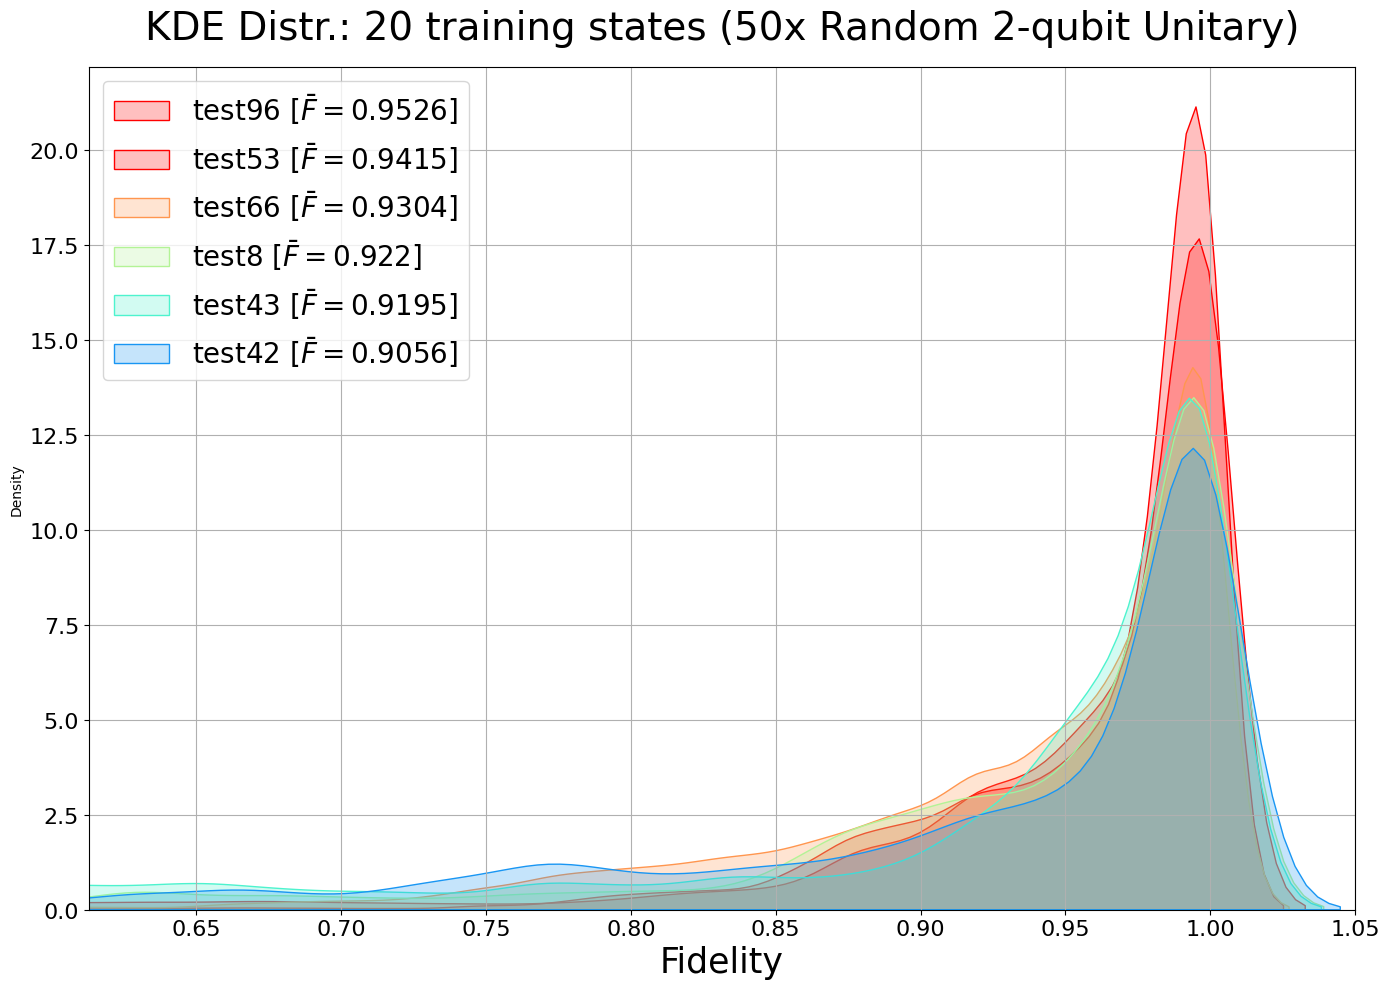

In [13]:
display =['test1','test6','test15','test57'] 
display =['test8','test53','test66', 'test96','test42','test43']
for trainsize in train_sizes:
    # plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,fixed_param_name,include = ['test22','test50','test44','test2','test104', 'test88','test146','test138', 'test63'] )
    plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,df_grouped,include = display )
    

[('test41', 0.8582649643784123), ('test33', 0.8646621485101326), ('test60', 0.8735027512695108), ('test89', 0.8782840154858572), ('test15', 0.8895828945360014), ('test1', 0.8999308638828142), ('test43', 0.91575948120015), ('test20', 0.9218697673984936), ('test57', 0.9293928482728345), ('test53', 0.9480892714355673), ('test96', 0.9504960782123464)]
test96: Tr(Q) = 29.3847, Var(λ) = 1.40e+02, κ = 3.83e+05, S = 0.050, S_VN = 0.081
test53: Tr(Q) = 81.8164, Var(λ) = 1.10e+03, κ = 3.28e+07, S = 0.007, S_VN = 0.188
test57: Tr(Q) = 162.6368, Var(λ) = 4.30e+03, κ = 3.51e+07, S = 0.003, S_VN = 0.222
test20: Tr(Q) = 0.2568, Var(λ) = 7.80e-03, κ = 5.93e+02, S = 0.465, S_VN = 0.403
test43: Tr(Q) = 15.2154, Var(λ) = 3.92e+01, κ = 7.92e+04, S = 0.044, S_VN = 0.155
test1: Tr(Q) = 191.2222, Var(λ) = 6.01e+03, κ = 4.56e+05, S = 0.007, S_VN = 0.289
test15: Tr(Q) = 132.0642, Var(λ) = 2.89e+03, κ = 3.71e+06, S = 0.051, S_VN = 0.491
test89: Tr(Q) = 0.0713, Var(λ) = 1.08e-03, κ = 4.13e+03, S = 0.313, S_VN = 

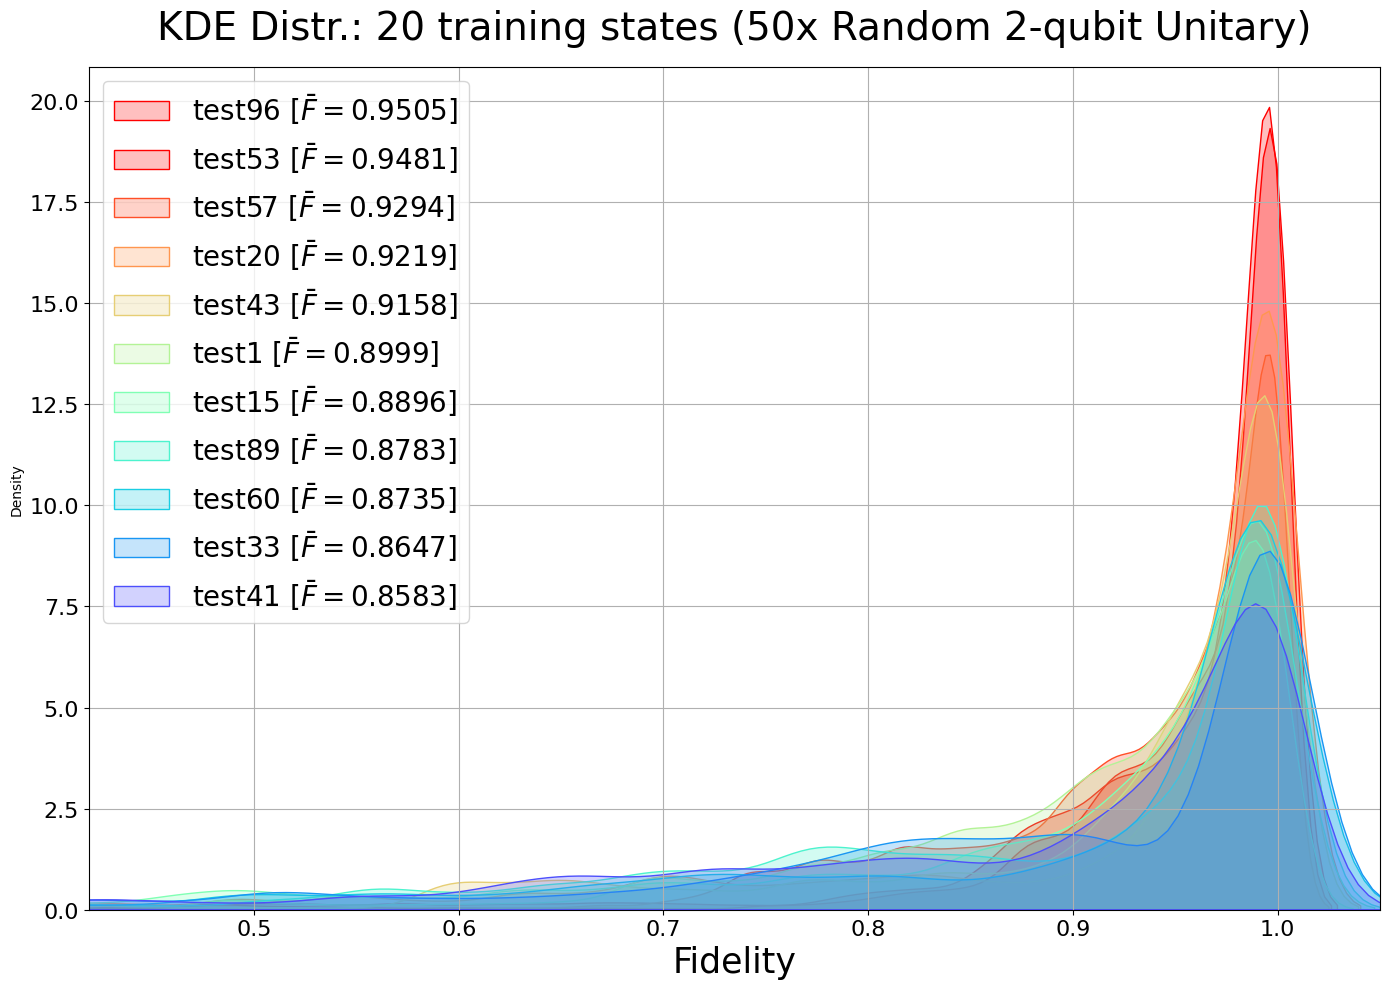

In [145]:
display =['test33','test80','test60','test53','test66', 'test96','test42','test43','test57','test66', 'test8','test41']
# display =['test8','test53','test66', 'test96','test42','test43', 'test41']
display =  ['test41', 'test57','test1','test53','test96','test43','test33','test89', 'test60','test20', 'test15']
for trainsize in train_sizes:
    # plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,fixed_param_name,include = ['test22','test50','test44','test2','test104', 'test88','test146','test138', 'test63'] )
    plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,df_grouped,include = display )
    

[('test43', 0.91575948120015)]


AttributeError: 'str' object has no attribute 'loc'

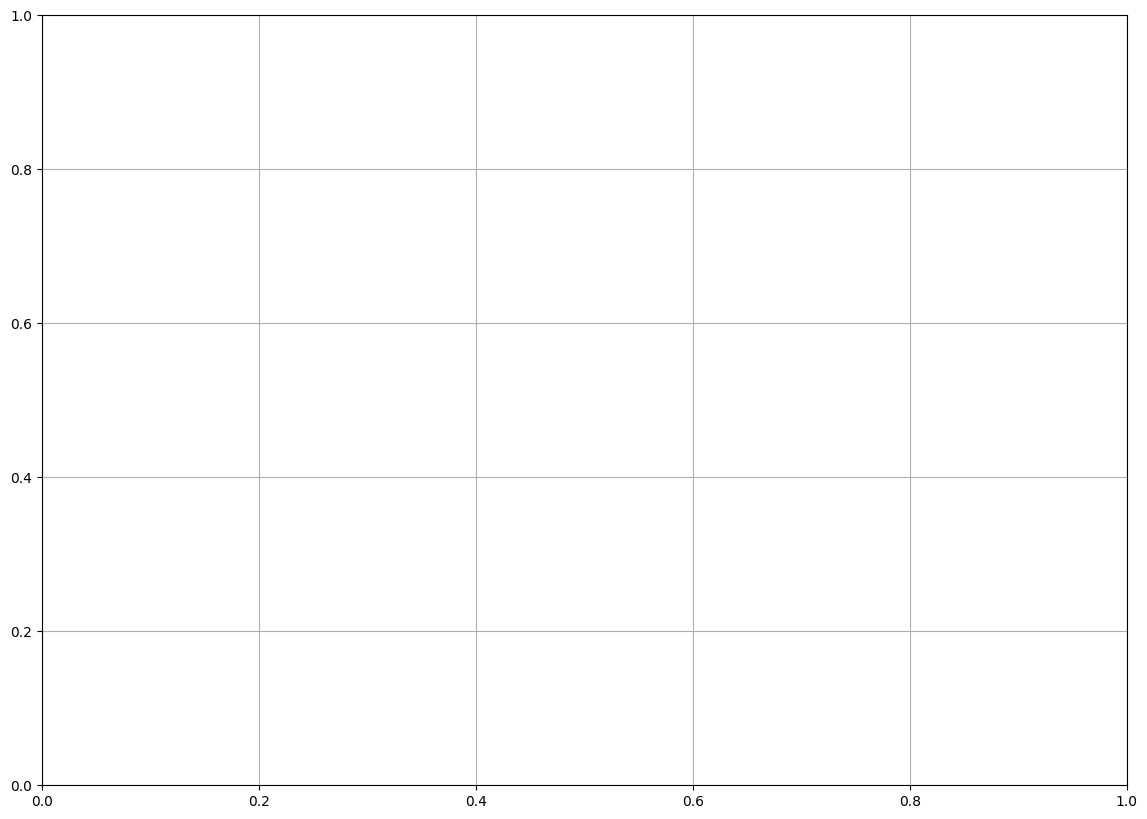

In [129]:

for trainsize in train_sizes:
    plot_combined_kde_fidelity(data_by_train_size[trainsize], trainsize,fixed_param_name,include =  ['test62','test69','test109','test145','test44','test43','test123'])

In [34]:
gate_prefix = f'U{N_ctrl}'
# Function to read data from pickle files and organize by test key
def read_data_by_gate(fixed_param_name, file_path,train_Size):
    data_by_test_key = {}
    
    train_path = os.path.join(file_path, f'{train_size}_training_states_preselected', fixed_param_name)
    
    for test_key in os.listdir(train_path):
        data_by_train_size[train_size] = {}
        data_trainsize = data_by_train_size[train_size]
        # train_size = 10
        train_path = os.path.join(file_path, f'{train_size}_training_states_preselected', fixed_param_name, '1.0K')
        if not os.path.exists(train_path):
            print(f"Not a dir: {train_path}")
            continue
        for test_key in os.listdir(train_path):
            test_path = os.path.join(train_path, test_key)
            if not os.path.isdir(test_path):
                continue
            print(folder_name,gate_prefix)
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                print(gate)
                pickle_file = os.path.join(test_path, folder_name, f'data_run_0.pickle')
                # print(pickle_file)
                if os.path.isfile(pickle_file):
                    gates.append(gate)
                    # print(pickle_file)
                    with open(pickle_file, 'rb') as f:
                        df = pickle.load(f)
                        if 'costs' in df and 'testing_results' in df:
                            try:
                                costs = [float(cost) for cost in df['costs'][0]]
                                if test_key not in data_by_test_key:
                                    data_by_test_key[test_key] = {}
                                if gate not in data_by_test_key[test_key]:
                                    data_by_test_key[test_key][gate] = []
                                data_by_test_key[test_key][gate].extend(costs)
                            except IndexError:
                                print(f"Error accessing costs or testing_results in {pickle_file}")
    print(f"Num gates: {len(gates)}")
    return data_by_test_key


train_size = 20
N_r = 1
trotter_step = 1
N_ctrl = 1
gate_prefix = f'U{N_ctrl}'
base_path = f'/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/'
fixed_param_name = 'fixed_params0'
file_path = base_path
# fixed_param_name = fixed_params[0]
data_by_test_key = read_data_by_gate(fixed_param_name, file_path,train_size)
# /Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_1/20_training_states_preselected/fixed_params0/1.0K/test49/U1_14/data_run_0.pickle

/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_1/20_training_states_preselected/fixed_params0/.DS_Store
/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_1/reservoirs_1/trotter_step_1/20_training_states_preselected/fixed_params0/1.0K
.DS_Store U1
test0 U1
test108 U1
test123 U1
test15 U1
test185 U1
test186 U1
test188 U1
test33 U1
test42 U1
test49 U1
Num gates: 0


In [47]:
data_by_test_key

{}

In [26]:
# Function to compute mean and standard deviation for each epoch across all gates for each test key
def compute_cost_statistics(data_by_test_key, epochs_to_show):
    statistics = {}
    for test_key, gates in data_by_test_key.items():
        mean_costs = []
        std_costs = []
        for epoch in range(epochs_to_show):
            epoch_costs = [costs[epoch] for costs in gates.values() if len(costs) > epoch]
            if epoch_costs:
                mean_costs.append(np.mean(epoch_costs))
                std_costs.append(np.std(epoch_costs))
        statistics[test_key] = (range(len(mean_costs)), mean_costs, std_costs)
    return statistics

# Function to plot cost history with standard deviation for each test key
def plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=None, epochs_to_show=None):
    # Filter test keys based on include argument
    if include is not None:
        data_by_test_key = {k: v for k, v in data_by_test_key.items() if k in include}

    # Determine the number of epochs to show
    if epochs_to_show is None:
        epochs_to_show = min(len(costs) for gates in data_by_test_key.values() for costs in gates.values())

    statistics = compute_cost_statistics(data_by_test_key, epochs_to_show)

    plt.figure(figsize=(10, 6))

    for test_key in include:
        epochs, mean_costs, std_costs = statistics[test_key]
        plt.plot(epochs, mean_costs, label=test_key)
        plt.fill_between(epochs, np.array(mean_costs) - np.array(std_costs), np.array(mean_costs) + np.array(std_costs), alpha=0.2)

    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title(f'Cost History with Standard Deviation for {fixed_param_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Plot with specific test keys and a limited number of epochs
include_keys = ['test108','test185','test15','test123', 'test49','test186'] 
epochs_to_show = 1500

plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=include_keys, epochs_to_show=epochs_to_show)

AttributeError: 'list' object has no attribute 'values'

In [32]:

# Function to read data from pickle files and organize by test key
def read_data_by_test_key(fixed_param_name, file_path):
    data_by_test_key = {}
    for train_size in train_sizes:
        train_path = os.path.join(file_path, f'{train_size}_training_states', fixed_param_name)
        if not os.path.exists(train_path):
            continue
        for test_key in os.listdir(train_path):
            test_path = os.path.join(train_path, test_key)
            if not os.path.isdir(test_path):
                continue
            for folder_name in sorted(os.listdir(test_path)):
                if folder_name.startswith(gate_prefix + "_"):
                    gate = folder_name
                    pickle_file = os.path.join(test_path, folder_name, f'{test_key}.pickle')
                    if os.path.isfile(pickle_file):
                        with open(pickle_file, 'rb') as f:
                            df = pickle.load(f)
                            if 'costs' in df and 'testing_results' in df:
                                try:
                                    costs = [float(cost) for cost in df['costs'][0]]
                                    if test_key not in data_by_test_key:
                                        data_by_test_key[test_key] = []
                                    data_by_test_key[test_key].extend(costs)
                                except IndexError:
                                    print(f"Error accessing costs or testing_results in {pickle_file}")
    return data_by_test_key

# Example usage
fixed_params = ['fixed_params0_basis3']

train_sizes = [20]
N_r = 1
trotter_step = 7
N_ctrl = 2
gate_prefix = f'U{N_ctrl}'
base_path = f'/Users/sophieblock/QRCCapstone/param_initialization/analog_results/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/'

file_path = base_path
fixed_param_name = fixed_params[0]
data_by_test_key = read_data_by_test_key(fixed_param_name, file_path)


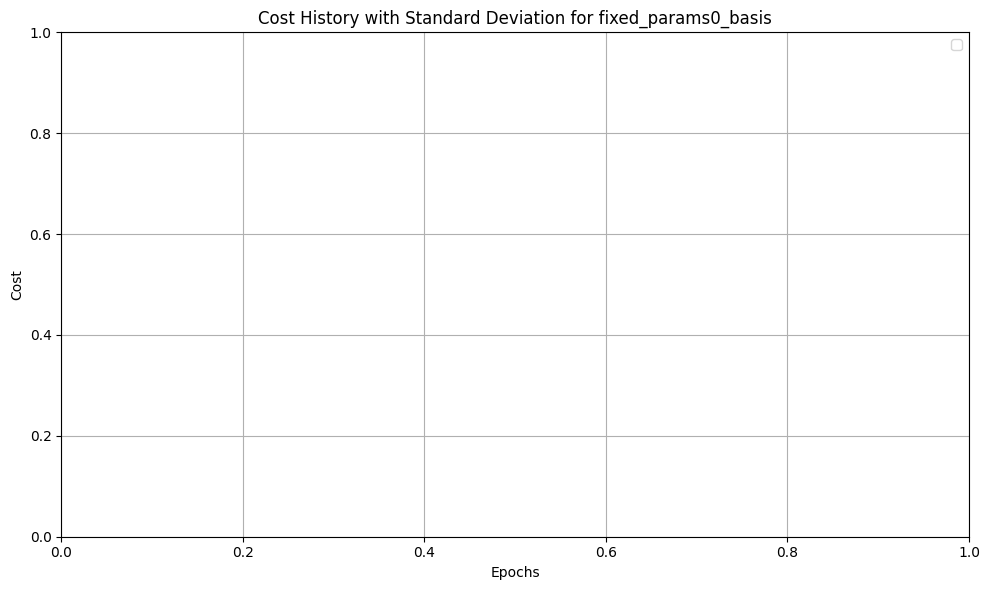

In [28]:
# Function to compute statistics for each test key
def compute_cost_statistics_for_test_key(costs, epochs_to_show):
    epochs = range(min(len(costs), epochs_to_show))
    mean_costs = costs[:epochs_to_show]
    std_costs = [0] * len(mean_costs)  # Standard deviation is zero since we have only one cost per epoch
    return epochs, mean_costs, std_costs

def plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=None, epochs_to_show=None):
    # Filter test keys based on include argument
    if include is not None:
        data_by_test_key = {k: v for k, v in data_by_test_key.items() if k in include}

    # Determine the number of epochs to show
    if epochs_to_show is None:
        epochs_to_show = min(len(costs) for costs in data_by_test_key.values())

    plt.figure(figsize=(10, 6))

    # Plot each test key's cost history
    for test_key, costs in data_by_test_key.items():
        epochs, mean_costs, std_costs = compute_cost_statistics_for_test_key(costs, epochs_to_show)
        plt.plot(epochs, mean_costs, label=test_key)
        plt.fill_between(epochs, np.array(mean_costs) - np.array(std_costs), np.array(mean_costs) + np.array(std_costs), alpha=0.2)

    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title(f'Cost History with Standard Deviation for {fixed_param_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot with specific test keys and a limited number of epochs
include_keys == ['test45','test18','test77','test4','test50','test85','test8','test62']
epochs_to_show = 1000

plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=include_keys, epochs_to_show=epochs_to_show)

In [ ]:
fixed_params = ['fixed_params28','fixed_params15','fixed_params2x3']
color_map = {
    'fixed_params28': 'orange',
    'fixed_params15': 'blue',
    'fixed_params2x3': 'green',
    
}
data_results = {}
train_sizes = [10]
N_r = 2
trotter_step = 1
N_ctrl = 1
gate_prefix = f'U{N_ctrl}'
base_path = f'/Users/sophieblock/QRCCapstone/param_initialization/analog_results_trainable_global/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/'

        
# Process each fixed parameter set and plot the results
for fixed_param_name in fixed_params:
    file_path = base_path
    data = read_data(fixed_param_name, file_path)
    if data:
        print(data)
        data_results[fixed_param_name] = data
        plot_cost_history(data, fixed_param_name, color_map[fixed_param_name])
        plot_fidelity_distribution(data, fixed_param_name, color_map[fixed_param_name])


In [ ]:
fixed_params = ['fixed_params28','fixed_params15','fixed_params2x3']
color_map = {
    'fixed_params28': 'orange',
    'fixed_params15': 'blue',
    'fixed_params2x3': 'green',
    
}


data_results = {}
# Define known unitaries

train_sizes = [10]
N_r = 2
trotter_step = 1
N_ctrl = 1
gate_prefix = f'U{N_ctrl}'
base_path = f'/Users/sophieblock/QRCCapstone/param_initialization/analog_results_trainable_global/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/'
for fixed_param_name in fixed_params:
    for train_size in train_sizes:
        file_path = os.path.join(base_path, f'{train_size}_training_states',f'{fixed_param_name}/')
        files_in_folder = os.listdir(file_path)
        for i,test_key in enumerate(files_in_folder):
            file_key_path = os.path.join(file_path,test_key)

            
            for folder_name in sorted(os.listdir(file_key_path)):
                if folder_name.startswith(gate_prefix + "_"):
                    gate = folder_name
                    pickle_file = os.path.join(file_key_path,folder_name,f'{test_key}.pickle')


                    with open(pickle_file, 'rb') as f:  # Note 'rb' here, which means read binary
                        df = pickle.load(f)



            
                    print(df.head())

In [ ]:
bathcount_0 = [
     '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/fixed_params11/test7/0/Hadamard/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
      '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/fixed_params11/test6/0/Hadamard/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
    '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/random0/0/Hadamard/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
     '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/random1/0/Hadamard/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
     '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/random2/0/Hadamard/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
    
]
bathcount_1 = [
     '/Users/sophieblock/QRCCapstone//param_initialization/analog_results/Nc_1//reservoirs_2/trotter_step_3/fixed_param_10/PauliZ/trainable_params_1.pickle',
      '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/fixed_params11/test6/0/PauliY/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
    '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/random0/0/PauliY/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
     '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/random1/0/PauliY/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
     '/Users/sophieblock/QRCCapstone/param_initialization/Nc1_Nr2_dt1/random2/0/PauliY/reservoirs_2/trotter_step_1/bath_False/data_run_0.pickle',
    
]
groups = [bathcount_0,bathcount_1]
from matplotlib.cm import get_cmap
# Prepare the plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
colors = cm.rainbow(np.linspace(0, 1, len(bathcount_0)))
# bathcount
for c,filenames in enumerate(groups): 
    
    for i, filename in enumerate(filenames):
        #print(filename)
        # Open the file and load the data
        with open(filename, 'rb') as f:  # Note 'rb' here, which means read binary
            df = pickle.load(f)
        
        # Extract data
        N_reserv = int(df['reservoirs'][0])
        N_ctrl = int(df['controls'][0])
        print(df['init_params_dict'][0])
        gate = df['Gate'][0]
        decoded_qobj = pickle.loads(base64.b64decode(gate.encode('utf-8')))
        #print(decoded_qobj)
        bath = filename.split('/')[-3]
        gate = filename.split('/')[-7]
        bath = bath.split('_')[-1]
        params_per_epoch = df['params_per_epoch'][0]
        num_epochs = len(params_per_epoch)

        time_steps = int(df['trotter_step'][0])
        
            
        #adam_costs = [float(i) for i in df['costs'][0]]
        #gen_costs = [float(i) for i in df['gen_cost'][0]]
        #costs = gen_costs+adam_costs
        costs = [float(i) for i in df['costs'][0]]
        #params_per_epoch = df['params_per_epoch'][0]
        test_results = df['testing_results'][0]
        epochs = list(range(len(costs)))
        step_size = df['opt_lr'][0]
        #print(step_size)
        
        #print(np.mean(test_results))
        # Cost Distribution
        bin_edges = np.linspace(start=min(test_results), stop=max(test_results), num=30)
        hist_data, bins = np.histogram(test_results, bins=bin_edges)
        normalized_hist_data = hist_data / sum(hist_data)
        #print(sum(hist_data))
        axs[0].hist(bins[:-1], bins, weights=normalized_hist_data, alpha=0.6, edgecolor="black", linewidth=.5, 
                    label=f'{gate} ($N_{{reserv}}={N_reserv}$, $time steps={time_steps}$)', color=colors[i])  # Modified label
    
        # Cost Per Epoch
        axs[1].plot(epochs, costs, label=f'Adam Step: {step_size} ($N_{{reserv}}={N_reserv}$, $time steps={time_steps}$)', color=colors[i], linewidth=0.75)  # Modified label
        axs[2].plot(epochs, params_per_epoch, label=f'Adam Step: {step_size} ($N_{{reserv}}={N_reserv}$, $time steps={time_steps}$)', color=colors[i], linewidth=0.75)  # Modified label

#print(type(params_per_epoch[0]) == bool)
# Finalize the plots
axs[0].set_title('Cost Distribution')
axs[0].legend()

axs[1].set_title('Cost Per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Cost')
axs[1].legend(loc='upper right')

# axs[2], axs[3], and axs[4] would similarly need data from both files and similar handling
# You need to load the respective data for taus, hxs, and js from both files and plot them on the respective axes.
# Make sure to label them distinctly so you can tell which series is for bath_True and which is for bath_False.

plt.tight_layout()
plt.show()

In [147]:
def get_n_params(type_model, Nr, steps, Nc):
    # print(type_model)
    if type_model:  # Analog model
        return steps * Nr * Nc + steps +3
    else:  # Digital model
        return steps * Nr * Nc+3
    
def get_df(data_i, trots, type_model, Nc):
    
    infidelity_data = {}
    infidelity_data_averaged = {}
    for gate, gate_data in data_i.items():
        for reservoir_count, trotter_data in gate_data.items():

            for trotter_step, results in trotter_data.items():
                #if not trotter_step in trots:
                #    continue
                infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])

                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                print(results)
                test_results = results['test_results']
                test_results = np.clip(test_results, 0, 1)
                average_fidelity = results['fidelity']
                average_infidelity = 1 - average_fidelity
                # Check if there are invalid infidelities
                # invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
                # if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                #     print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                #     print(f"invalid_infidelities: {invalid_infidelities}")
                #     continue
                infidelity_res = 1 - np.array(test_results)
                
                
                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)
                infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
     
    all_trotter_steps = sorted(infidelity_data.keys())



    violin_plot_data_all = []
    for trotter_step, res_data in infidelity_data.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            log_infidelities = [np.log10(infidelity) if infidelity > 0 else -np.inf for infidelity in infidelities]  # Calculate log
            violin_plot_data_all.extend([(trotter_step, reservoir_count, log_inf, n_param) for log_inf in log_infidelities])

    df_violin_all = pd.DataFrame(violin_plot_data_all, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)','n_param'])

    # Prepare data for violin plot with log(infidelity)
    violin_plot_data_avg = []
    for trotter_step, res_data in infidelity_data_averaged.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            for infidelity in infidelities:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
                violin_plot_data_avg.append((trotter_step, reservoir_count, log_infidelity, n_param))
                
    df_violin_avg = pd.DataFrame(violin_plot_data_avg, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)', 'n_param'])
    return df_violin_all,df_violin_avg
def find_matching_params_trotter_steps(N_ctrl, N_reserv, Nc):
    if N_ctrl == 3:
        trots = np.arange(1,60,1) 
    else:
        trots = np.arange(1,60,1)

    # Dictionary to store Trotter steps by parameter count for digital and analog models
    digital_param_steps = {}
    analog_param_steps = {}

    for trotter_step in trots:
        # Get number of parameters for digital (type_model = 0) and analog (type_model = 1) models
        n_params_digital = get_n_params(0, N_reserv, trotter_step, Nc)
        n_params_analog = get_n_params(1, N_reserv, trotter_step, Nc)

        # Store Trotter steps grouped by parameter counts
        if n_params_digital not in digital_param_steps:
            digital_param_steps[n_params_digital] = []
        digital_param_steps[n_params_digital].append(trotter_step)

        if n_params_analog not in analog_param_steps:
            analog_param_steps[n_params_analog] = []
        analog_param_steps[n_params_analog].append(trotter_step)

    # Separate lists for matching Trotter steps
    matching_digital_steps = []
    matching_analog_steps = []

    # Find common parameter counts between digital and analog models
    for param_count in digital_param_steps:
        if param_count in analog_param_steps:
            # print(param_count)
            matching_digital_steps.extend(digital_param_steps[param_count])
            matching_analog_steps.extend(analog_param_steps[param_count])

    return matching_digital_steps, matching_analog_steps

# Example usage:
N_ctrl = 3
N_reserv = 1
Nc = N_ctrl
digital_trots, analog_trots = find_matching_params_trotter_steps(N_ctrl, N_reserv, Nc)



print("Matching Trotter steps for Digital model:", digital_trots)
print("Matching Trotter steps for Analog model:", analog_trots)



Matching Trotter steps for Digital model: [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56]
Matching Trotter steps for Analog model: [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42]
